<a href="https://colab.research.google.com/github/pedromperezc/CEIA/blob/master/AP/Desafio_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# REDES NUERONALES RECURRENTES

Implementacion con un set de sañales trigonometricas.

## Funciones comunes a todas la partes

In [1]:
# Librerias
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error

In [2]:
# Funcion para generar base de datos de señales
def generate_time_series(batch_size, n_steps, n_future):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps + n_future)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps + n_future) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [3]:
# función que plotea un array de curvas (inputs y outputs)
def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
  r, c = 3, 5
  fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
  for row in range(r):
    for col in range(c):
        plt.sca(axes[row][col])
        ix = col + row*c
        plt.plot(series[ix, :], ".-")
        if y is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
        if y_pred is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
        if y_pred_std is not None:
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
            plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
        plt.grid(True)
        plt.hlines(0, 0, 100, linewidth=1)
        plt.axis([0, len(series[ix, :])+len(y[ix]), -1, 1])
        if x_label and row == r - 1:
          plt.xlabel(x_label, fontsize=16)
        if y_label and col == 0:
          plt.ylabel(y_label, fontsize=16, rotation=0)
  plt.show()



In [4]:
# Clase dataset para luego armar los dataloader
class TimeSeriesDataset(Dataset):
  def __init__(self, X, y=None, train=True):
    self.X = X
    self.y = y
    self.train = train

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    if self.train:
      return torch.from_numpy(self.X[ix]), torch.from_numpy(self.y[ix])
    return torch.from_numpy(self.X[ix]) # si no es train, solo devuelve el X


In [46]:
# funciones de entrenamiento

from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=5):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    criterion = torch.nn.MSELoss()

    for epoch in range(epochs+1):
        print("epoch numero: ", epoch)
        bar = tqdm(dataloader['train'])
        model.train()
        train_loss = []
        eval_loss = []
        for batch in bar:
            X, y = batch
            #print(X.shape)
            #input()
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)

            #print('y shape')
            # print(y.shape)
            y = y.view(y.shape[0], -1) # aca elimino la dim de la profundidad
            # print(y.shape)
            #print(' y hat shape')
            #print(y_hat.shape)
            
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            bar.set_description(f"train_loss {np.mean(train_loss):.5f}")
        
        bar = tqdm(dataloader['eval'])
        model.eval()
        
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                y = y.view(y.shape[0], -1)
                loss = criterion(y_hat, y)
                eval_loss.append(loss.item())
                bar.set_description(f"valid_loss {np.mean(eval_loss):.5f}")
        
def predict(model, dataloader):
    model.eval()
    with torch.no_grad():
        preds = torch.tensor([]).to(device)
        for batch in dataloader:
            X = batch
            X = X.to(device)
            pred = model(X)
            preds = torch.cat([preds, pred])
        return preds

In [47]:
# función para imprimir parametros del modelo.
def imp_param(model):
  print('-'*84)
  print('PARAMETROS DEL MODELO')
  print('-'*84)
  for name, param in model.named_parameters():
    if param.requires_grad: 
      print('Nombre del parámetro: ')
      print(name)
      print('Tamaño del parámetro: ')
      print(param.data.shape)
      print()

## Primera aproximación de recurrencia, empleado un perceptrón multicapa.
(adapación de un MLP para predecir el valor futuro de un señal)



In [48]:
n_steps = 50
n_future = 1
series = generate_time_series(10000, n_steps, n_future)
X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

X and y Train shape
(7000, 50, 1) (7000, 1, 1)
X and y Valid shape
(2000, 50, 1) (2000, 1, 1)
X and y Test shape
(1000, 50, 1) (1000, 1, 1)


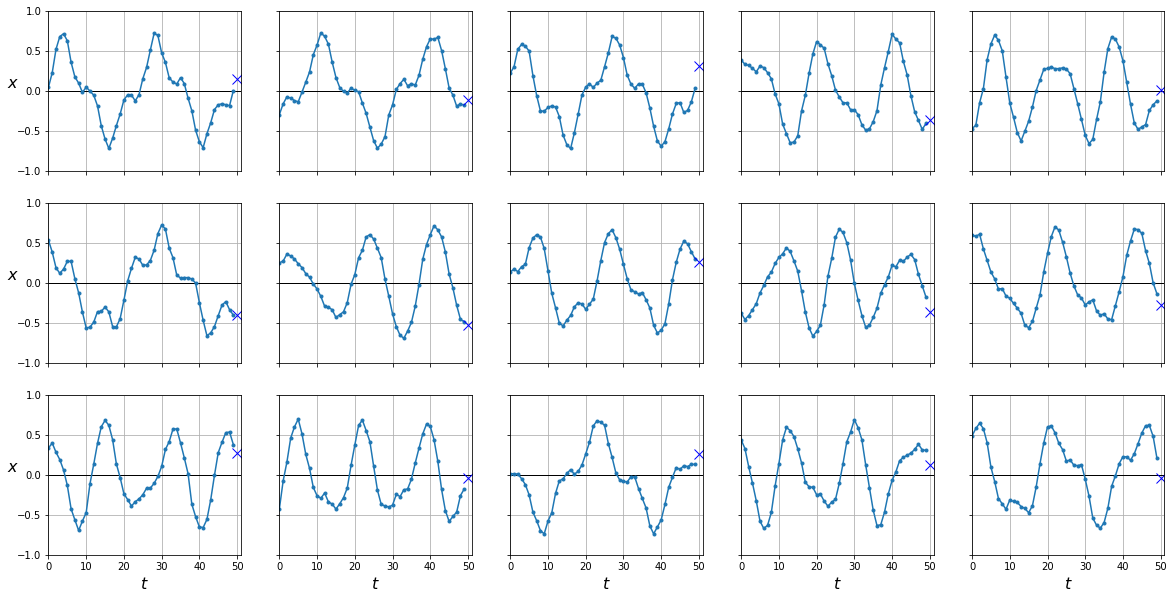

In [49]:
plot_series(X_test, y_test)

In [50]:
dataset = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}

MLP para comparar luego con RNN

In [51]:
class MLP(torch.nn.Module):
  def __init__(self, n_in=n_steps, n_out=n_future):
    super().__init__()
    self.fc = torch.nn.Linear(n_in, n_out)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

# n_steps y out_future definidos arriba
mlp = MLP(n_steps, n_future)
mlp

MLP(
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [52]:
fit(mlp, dataloader)

epoch numero:  0


valid_loss 0.04878: 100%|██████████| 32/32 [00:00<00:00, 262.01it/s]


epoch numero:  1


valid_loss 0.02910: 100%|██████████| 32/32 [00:00<00:00, 293.95it/s]


epoch numero:  2


valid_loss 0.02046: 100%|██████████| 32/32 [00:00<00:00, 180.37it/s]


epoch numero:  3


valid_loss 0.01528: 100%|██████████| 32/32 [00:00<00:00, 186.23it/s]


epoch numero:  4


valid_loss 0.01221: 100%|██████████| 32/32 [00:00<00:00, 196.79it/s]


epoch numero:  5


valid_loss 0.01029: 100%|██████████| 32/32 [00:00<00:00, 176.37it/s]


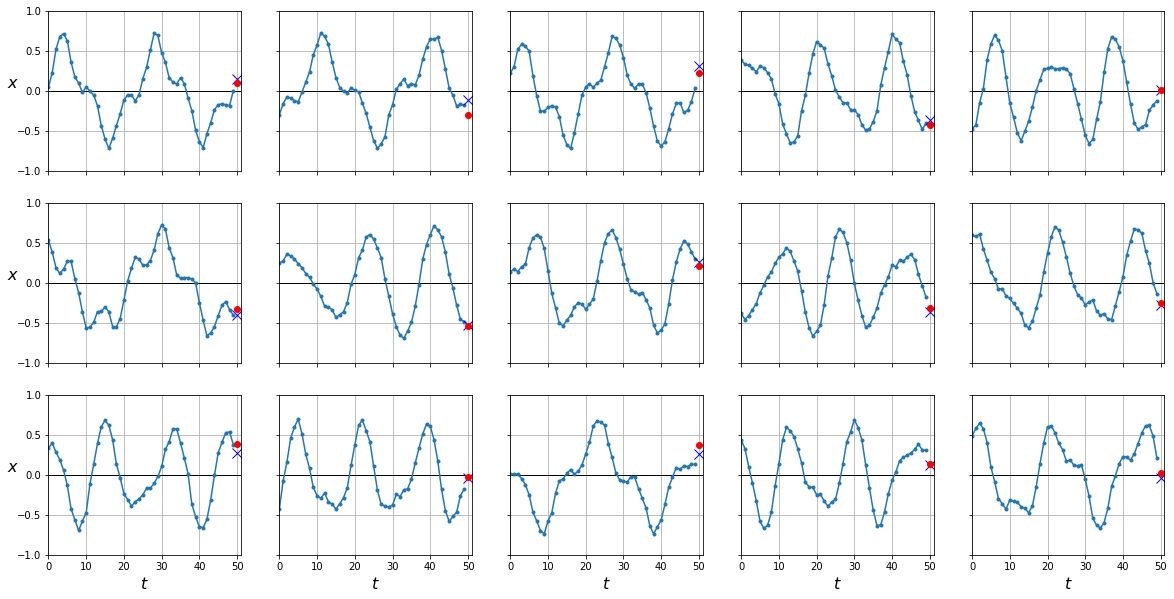

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.01015543

In [53]:
y_pred = predict(mlp, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred)

## Veamos ahora una RNN básica de 1 sola neurona

In [54]:
class SimpleRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=1, num_layers=1, batch_first=True)

  def forward(self, x):
    x, h = self.rnn(x) 
    # solo queremos la última salidas
    #return x[:,-10:]
    return x[:,-1:,-1]

rnn = SimpleRNN()
rnn

SimpleRNN(
  (rnn): RNN(1, 1, batch_first=True)
)

In [55]:
# veamos que arroja nuestra rnn

entrada = torch.rand(50)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.7233, 0.3642, 0.6019, 0.7882, 0.8416, 0.2085, 0.0387, 0.6929, 0.5041,
        0.4683, 0.4498, 0.8974, 0.1709, 0.7569, 0.8452, 0.4125, 0.9767, 0.7086,
        0.9116, 0.8525, 0.1125, 0.9215, 0.4761, 0.4407, 0.4687, 0.0188, 0.5610,
        0.1461, 0.4252, 0.6368, 0.4586, 0.3373, 0.0337, 0.4921, 0.8309, 0.5370,
        0.3622, 0.0900, 0.7375, 0.8304, 0.9164, 0.3537, 0.1278, 0.9950, 0.9789,
        0.7435, 0.8102, 0.0447, 0.7336, 0.6667])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 50, 1])

In [56]:
# paso la entrada a la red
salida = rnn(entrada)

print('salida de la red (largo igual al input):')
print(salida)

print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[-0.2023]], grad_fn=<SelectBackward0>)
salida shape:
torch.Size([1, 1])


In [57]:
# ahora el vamos a pasar un set del dataset...

In [58]:

# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como input:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como input:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [59]:
nr = 0
serie = xs[nr]
deseado = ys[nr]
print('input shape:')
print(serie.shape)
salida = rnn(serie[None,:])
print('salida de la red (largo igual al input):')
print(salida.shape)
print('tamaño del valor deseado:')
print(deseado.shape)


input shape:
torch.Size([50, 1])
salida de la red (largo igual al input):
torch.Size([1, 1])
tamaño del valor deseado:
torch.Size([1, 1])


In [60]:
fit(rnn, dataloader)

epoch numero:  0


valid_loss 0.42823: 100%|██████████| 32/32 [00:00<00:00, 144.52it/s]


epoch numero:  1


valid_loss 0.34316: 100%|██████████| 32/32 [00:00<00:00, 152.59it/s]


epoch numero:  2


valid_loss 0.28494: 100%|██████████| 32/32 [00:00<00:00, 145.41it/s]


epoch numero:  3


valid_loss 0.24120: 100%|██████████| 32/32 [00:00<00:00, 155.76it/s]


epoch numero:  4


valid_loss 0.20697: 100%|██████████| 32/32 [00:00<00:00, 153.76it/s]


epoch numero:  5


valid_loss 0.17895: 100%|██████████| 32/32 [00:00<00:00, 134.71it/s]


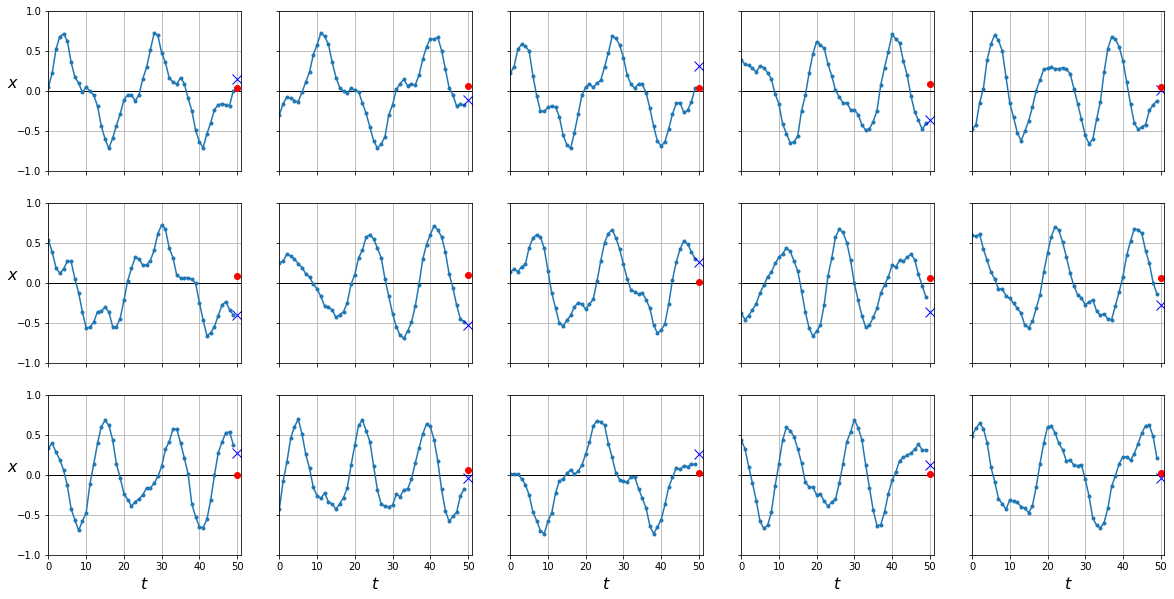

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.17671427

In [61]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

## Comparacion de parámetros entre MLP y RNN implementada

In [62]:
# parámetros en el MLP

imp_param(mlp)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 50])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [63]:
# parámetros en el RNN

imp_param(rnn)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([1, 1])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([1])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([1])



## Incorporamos más neuronas en la RNN

In [64]:
class RNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=1, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    # get the last output and apply linear layer
    #print('x shape')
    #print(x.shape)
    #print('x shape [:,-1:]')
    #print(x[:,-1:].shape)
    y = self.fc(x[:,-1])
    
    return y

rnn_2 = RNN()

In [65]:
# parámetros en el RNN

imp_param(rnn_2)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



In [66]:
# veamos que arroja nuestra rnn_2

entrada = torch.rand(20)
print('entrada')
print(entrada)
# le agrego las dimensiones necesarias
entrada = entrada[None, :, None]
print('entrada con nuevas dimensiones')
print('[batch, Length, nr_features] ')
entrada.shape

entrada
tensor([0.3487, 0.3312, 0.0835, 0.6573, 0.6061, 0.6732, 0.2698, 0.5954, 0.7987,
        0.0772, 0.3388, 0.0010, 0.0972, 0.2247, 0.9054, 0.1107, 0.1616, 0.5259,
        0.6358, 0.0819])
entrada con nuevas dimensiones
[batch, Length, nr_features] 


torch.Size([1, 20, 1])

In [67]:
# paso la entrada a la red
salida = rnn_2(entrada)

print('salida de la red (largo igual al input):')
print(salida)
print('salida shape:')
print(salida.shape)

salida de la red (largo igual al input):
tensor([[0.2550]], grad_fn=<AddmmBackward0>)
salida shape:
torch.Size([1, 1])


In [68]:
fit(rnn_2, dataloader)

epoch numero:  0


valid_loss 0.02998: 100%|██████████| 32/32 [00:00<00:00, 131.60it/s]


epoch numero:  1


valid_loss 0.01020: 100%|██████████| 32/32 [00:00<00:00, 133.40it/s]


epoch numero:  2


valid_loss 0.00719: 100%|██████████| 32/32 [00:00<00:00, 119.17it/s]


epoch numero:  3


valid_loss 0.00638: 100%|██████████| 32/32 [00:00<00:00, 133.67it/s]


epoch numero:  4


valid_loss 0.00578: 100%|██████████| 32/32 [00:00<00:00, 122.02it/s]


epoch numero:  5


valid_loss 0.00541: 100%|██████████| 32/32 [00:00<00:00, 132.08it/s]


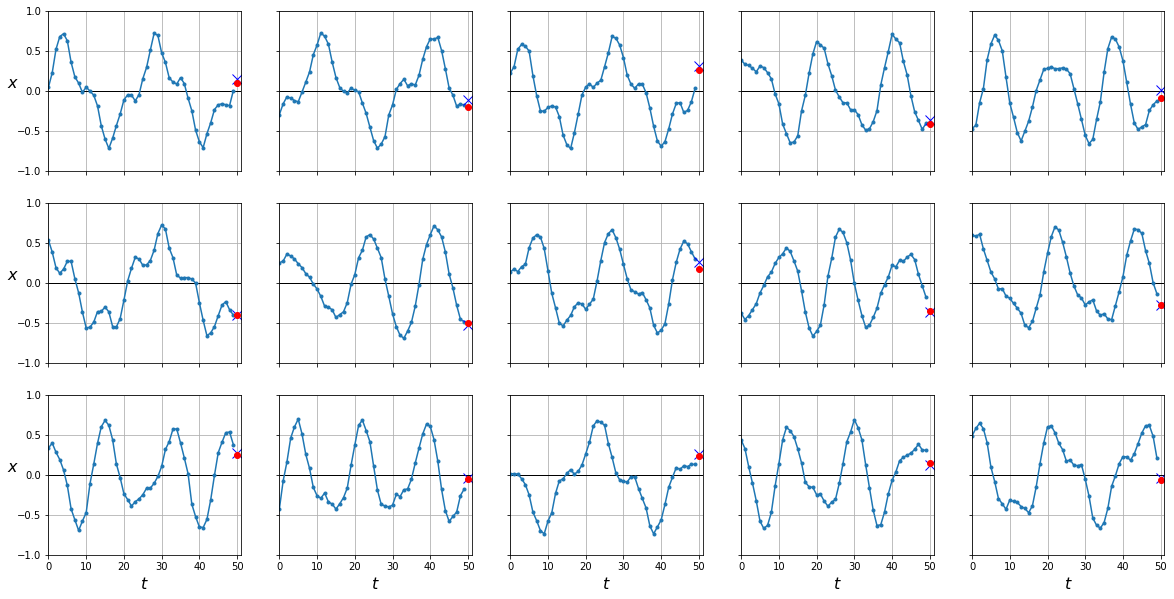

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0057043354

In [69]:
y_pred = predict(rnn_2, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())


y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), y_pred.cpu())

## Le agregamos 1 layer mas, para tener mas profundidad





In [70]:
class DeepRNN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=20, num_layers=2, batch_first=True)
    self.fc = torch.nn.Linear(20, 1)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [71]:
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)

epoch numero:  0


valid_loss 0.01318: 100%|██████████| 32/32 [00:00<00:00, 114.99it/s]


epoch numero:  1


valid_loss 0.00530: 100%|██████████| 32/32 [00:00<00:00, 109.03it/s]


epoch numero:  2


valid_loss 0.00442: 100%|██████████| 32/32 [00:00<00:00, 46.90it/s]


epoch numero:  3


valid_loss 0.00371: 100%|██████████| 32/32 [00:00<00:00, 65.53it/s]


epoch numero:  4


valid_loss 0.00344: 100%|██████████| 32/32 [00:00<00:00, 66.27it/s]


epoch numero:  5


valid_loss 0.00332: 100%|██████████| 32/32 [00:00<00:00, 47.28it/s]


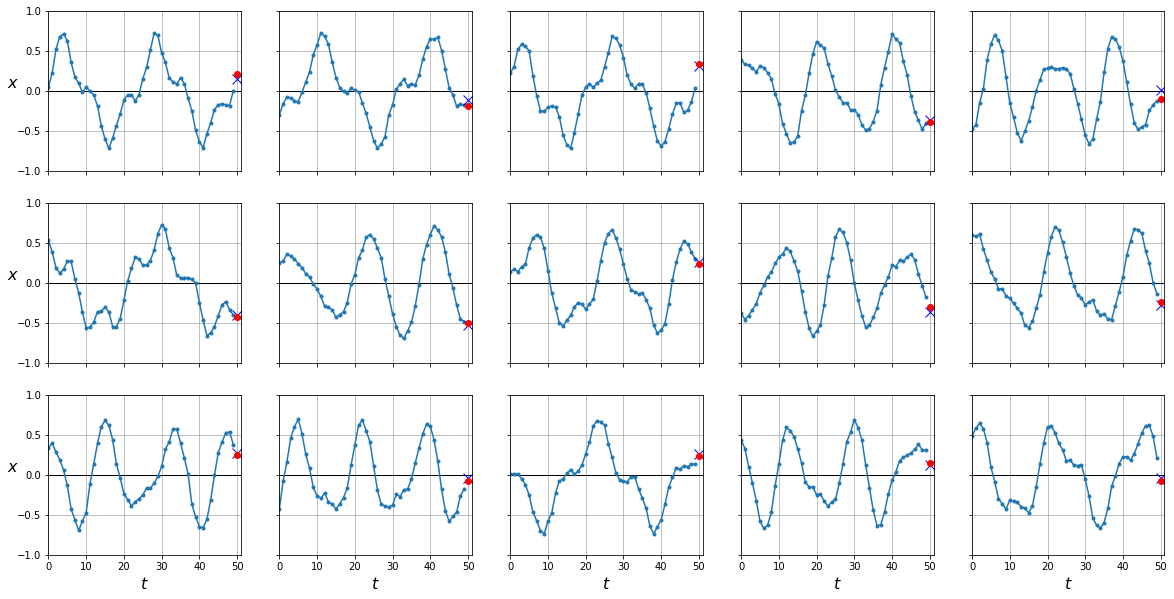

y_test shape:
(1000, 1, 1)
y_pred shape:
torch.Size([1000, 1])
Error cuadratico medio de la estimación final: 


0.0035662914

In [72]:
y_pred = predict(rnn_deep, dataloader['test'])
plot_series(X_test, y_test, y_pred.cpu().numpy())

y_testb = np.squeeze(y_test)
print('y_test shape:')
print(y_test.shape)
print('y_pred shape:')
print(y_pred.shape)
print('Error cuadratico medio de la estimación final: ')
mean_squared_error(np.squeeze(y_test), np.squeeze(y_pred))

In [73]:
# parámetros en el RNN

imp_param(rnn_deep)

------------------------------------------------------------------------------------
PARAMETROS DEL MODELO
------------------------------------------------------------------------------------
Nombre del parámetro: 
rnn.weight_ih_l0
Tamaño del parámetro: 
torch.Size([20, 1])

Nombre del parámetro: 
rnn.weight_hh_l0
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l0
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.weight_ih_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.weight_hh_l1
Tamaño del parámetro: 
torch.Size([20, 20])

Nombre del parámetro: 
rnn.bias_ih_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
rnn.bias_hh_l1
Tamaño del parámetro: 
torch.Size([20])

Nombre del parámetro: 
fc.weight
Tamaño del parámetro: 
torch.Size([1, 20])

Nombre del parámetro: 
fc.bias
Tamaño del parámetro: 
torch.Size([1])



# predecimos 10 valores a futuro, colocando la última predicción en la entrada, hasta llegar a 10 pasos iterativos

series shape
(10000, 60, 1)
X and y Train shape
(7000, 50, 1) (7000, 10, 1)
X and y Valid shape
(2000, 50, 1) (2000, 10, 1)
X and y Test shape
(1000, 50, 1) (1000, 10, 1)


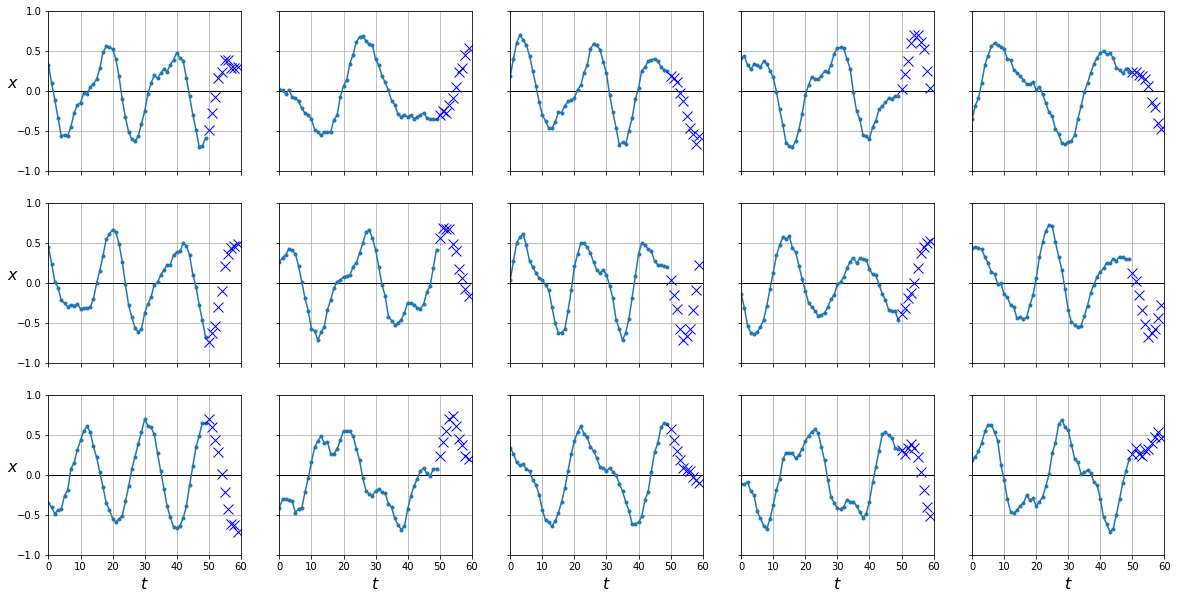

(1000, 10, 1)
(1000, 1, 1)


In [74]:
# generamos unos nuevos datos para tener con qué comparar

n_steps = 50
n_future = 10

series = generate_time_series(10000, n_steps, n_future)
print('series shape')
print(series.shape)

X_train, y_train = series[:7000, :n_steps], series[:7000, -n_future:]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -n_future:]
X_test, y_test = series[9000:, :n_steps], series[9000:, -n_future:]
print('X and y Train shape')
print(X_train.shape, y_train.shape)

print('X and y Valid shape')
print(X_valid.shape, y_valid.shape)

print('X and y Test shape')
print(X_test.shape, y_test.shape)

# ploteamos
plot_series(X_test, y_test)
print(y_test.shape)
print(y_test[:,:1,:].shape)

In [75]:
#  tenemos q armar un nuevo dataloader que pase 1 solo valor a futuro
# pero tengamos los siguientes 9 para ver el error de nuestra propia iteración
dataset = {
    'train': TimeSeriesDataset(X_train, y_train[:,:1,:]),
    'eval': TimeSeriesDataset(X_valid, y_valid[:,:1,:]),
    'test': TimeSeriesDataset(X_test, y_test[:,:1,:], train=False)
}

dataloader = {
    'train': DataLoader(dataset['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset['test'], shuffle=False, batch_size=64)
}
print(type(dataloader))


<class 'dict'>


In [76]:
# veo primero una muestra del dataloader

xs, ys = next(iter(dataloader['train']))
print('tamaño del xs que le paso como input:')
print('batch x largo x nro features (si paso mas de 1 feature por tiempo)')
print(xs.shape)
print('---------')
print('tamaño del ys que le paso como output:')
print('batch x largo x nro features(si paso mas de 1 feature por tiempo)')
print(ys.shape)

tamaño del xs que le paso como input:
batch x largo x nro features (si paso mas de 1 feature por tiempo)
torch.Size([64, 50, 1])
---------
tamaño del ys que le paso como output:
batch x largo x nro features(si paso mas de 1 feature por tiempo)
torch.Size([64, 1, 1])


In [77]:
# entreno de nueva la ultima red y graficamos
rnn_deep = DeepRNN()
fit(rnn_deep, dataloader)


epoch numero:  0


valid_loss 0.01280: 100%|██████████| 32/32 [00:00<00:00, 83.93it/s]


epoch numero:  1


valid_loss 0.00559: 100%|██████████| 32/32 [00:00<00:00, 58.78it/s]


epoch numero:  2


valid_loss 0.00381: 100%|██████████| 32/32 [00:00<00:00, 43.94it/s]


epoch numero:  3


valid_loss 0.00365: 100%|██████████| 32/32 [00:00<00:00, 83.70it/s]


epoch numero:  4


valid_loss 0.00318: 100%|██████████| 32/32 [00:00<00:00, 111.28it/s]


epoch numero:  5


valid_loss 0.00309: 100%|██████████| 32/32 [00:00<00:00, 68.78it/s]


In [78]:
print(xs.shape)
#predict(rnn_deep, xs)
sal = rnn_deep(xs)
sal.shape

torch.Size([64, 50, 1])


torch.Size([64, 1])

(1000, 10)


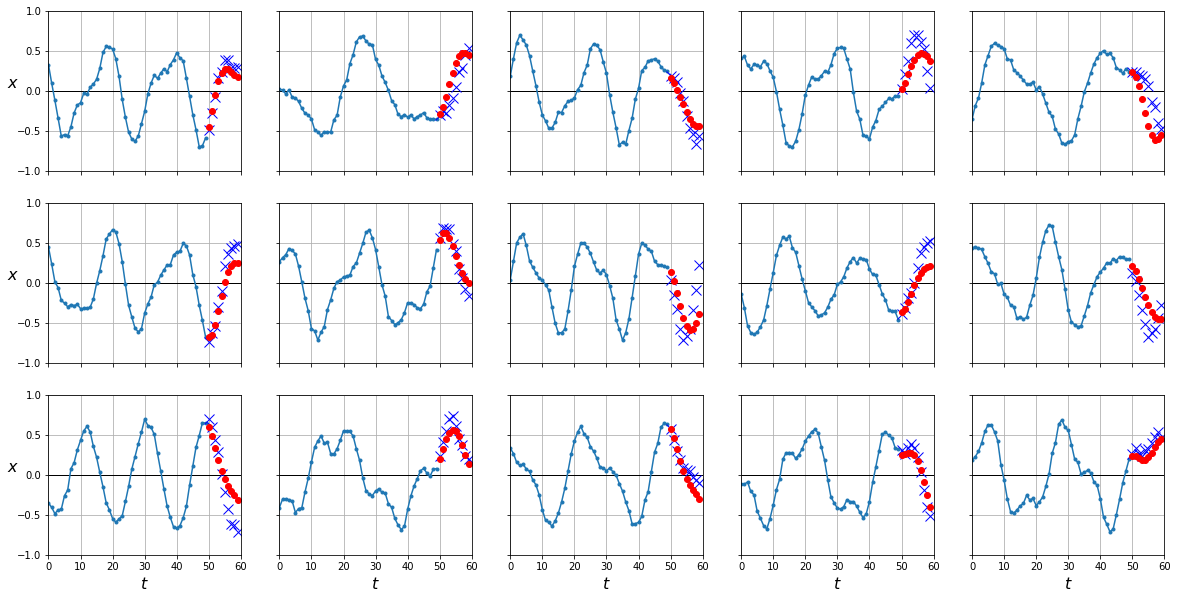

(1000, 10, 1)
(1000, 10)


0.027749028

In [79]:
# graficamos

X = X_test
for step_ahead in range(10):
    #print(step_ahead)
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0) # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    #print(inputs.shape)
    y_pred_one = predict(rnn_deep, inputs).cpu().numpy()
    #print(y_pred_one.shape)
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)
    #print(X.shape)

y_pred = X[:, n_steps:, -1]
print(y_pred.shape)
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

epoch numero:  0


valid_loss 0.00635: 100%|██████████| 32/32 [00:00<00:00, 170.58it/s]


epoch numero:  1


valid_loss 0.00483: 100%|██████████| 32/32 [00:00<00:00, 137.83it/s]


epoch numero:  2


valid_loss 0.00407: 100%|██████████| 32/32 [00:00<00:00, 147.99it/s]


epoch numero:  3


valid_loss 0.00354: 100%|██████████| 32/32 [00:00<00:00, 78.33it/s]


epoch numero:  4


valid_loss 0.00329: 100%|██████████| 32/32 [00:00<00:00, 134.44it/s]


epoch numero:  5


valid_loss 0.00310: 100%|██████████| 32/32 [00:00<00:00, 142.79it/s]


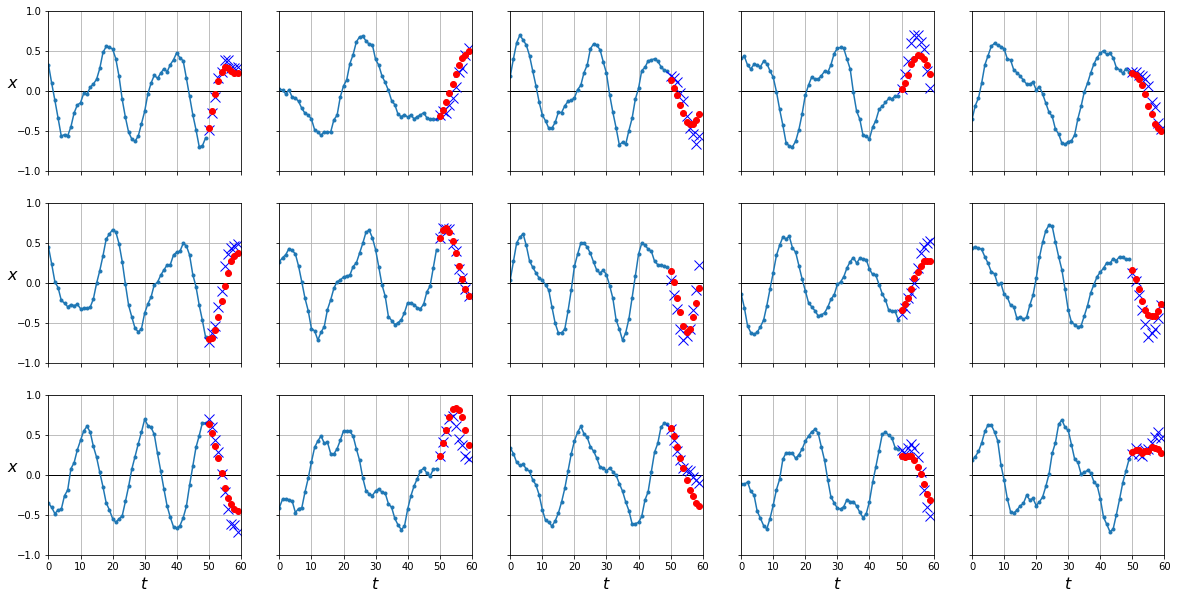

(1000, 10, 1)
(1000, 10)


0.017902734

In [80]:
# lo comparamos en el mlp
# entreno de nuevo el mlp con los nuevos datos y graficamos

fit(mlp, dataloader)

X = X_test
for step_ahead in range(10):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
    y_pred_one = predict(mlp, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)


## Crear una RNN que tenga 10 salidas y mejore el error del MLP usado antes. 

* Largo de entrada 50 muestras.

* Predicción a futuro 10 muestras.


In [45]:
dataset_2 = {
    'train': TimeSeriesDataset(X_train, y_train),
    'eval': TimeSeriesDataset(X_valid, y_valid),
    'test': TimeSeriesDataset(X_test, y_test, train=False)
}

dataloader_2 = {
    'train': DataLoader(dataset_2['train'], shuffle=True, batch_size=64),
    'eval': DataLoader(dataset_2['eval'], shuffle=False, batch_size=64),
    'test': DataLoader(dataset_2['test'], shuffle=False, batch_size=64)
}

In [81]:
class RNN_improved(torch.nn.Module):
  def __init__(self):
    super().__init__()

    self.rnn1 = torch.nn.RNN(input_size=1, hidden_size=16, num_layers=4, batch_first=True, bidirectional=True)
    self.rnn2 = torch.nn.RNN(input_size=32, hidden_size=64, num_layers=4, batch_first=True, bidirectional=True)
    self.rnn3 = torch.nn.RNN(input_size=128, hidden_size=64, num_layers=4, batch_first=True, )

    self.linear = torch.nn.Linear(in_features=64, out_features=10)

  def forward(self, x):
    x, h = self.rnn1(x) 
    x, h = self.rnn2(x)
    x, h = self.rnn3(x)
    x = self.linear (x)
    # return x[:,-10:]
    return x[:,-10:,-1]

rnn_improved = RNN_improved()
rnn_improved

RNN_improved(
  (rnn1): RNN(1, 16, num_layers=4, batch_first=True, bidirectional=True)
  (rnn2): RNN(32, 64, num_layers=4, batch_first=True, bidirectional=True)
  (rnn3): RNN(128, 64, num_layers=4, batch_first=True)
  (linear): Linear(in_features=64, out_features=10, bias=True)
)

In [82]:
fit(rnn_improved, dataloader_2, epochs=50)

epoch numero:  0


valid_loss 0.06153: 100%|██████████| 32/32 [00:02<00:00, 15.90it/s]


epoch numero:  1


valid_loss 0.02354: 100%|██████████| 32/32 [00:01<00:00, 16.55it/s]


epoch numero:  2


valid_loss 0.02175: 100%|██████████| 32/32 [00:02<00:00, 15.73it/s]


epoch numero:  3


valid_loss 0.02328: 100%|██████████| 32/32 [00:01<00:00, 16.06it/s]


epoch numero:  4


valid_loss 0.01034: 100%|██████████| 32/32 [00:02<00:00, 15.88it/s]


epoch numero:  5


valid_loss 0.00979: 100%|██████████| 32/32 [00:01<00:00, 16.22it/s]


epoch numero:  6


valid_loss 0.00717: 100%|██████████| 32/32 [00:01<00:00, 16.06it/s]


epoch numero:  7


valid_loss 0.00538: 100%|██████████| 32/32 [00:02<00:00, 15.80it/s]


epoch numero:  8


valid_loss 0.00414: 100%|██████████| 32/32 [00:01<00:00, 16.01it/s]


epoch numero:  9


valid_loss 0.00437: 100%|██████████| 32/32 [00:01<00:00, 16.10it/s]


epoch numero:  10


valid_loss 0.00395: 100%|██████████| 32/32 [00:02<00:00, 14.75it/s]


epoch numero:  11


valid_loss 0.00528: 100%|██████████| 32/32 [00:02<00:00, 15.67it/s]


epoch numero:  12


valid_loss 0.00347: 100%|██████████| 32/32 [00:02<00:00, 14.10it/s]


epoch numero:  13


valid_loss 0.00278: 100%|██████████| 32/32 [00:02<00:00, 15.50it/s]


epoch numero:  14


valid_loss 0.00651: 100%|██████████| 32/32 [00:01<00:00, 16.24it/s]


epoch numero:  15


valid_loss 0.00318: 100%|██████████| 32/32 [00:01<00:00, 16.21it/s]


epoch numero:  16


valid_loss 0.00281: 100%|██████████| 32/32 [00:02<00:00, 15.86it/s]


epoch numero:  17


valid_loss 0.00331: 100%|██████████| 32/32 [00:02<00:00, 15.83it/s]


epoch numero:  18


valid_loss 0.00255: 100%|██████████| 32/32 [00:02<00:00, 15.64it/s]


epoch numero:  19


valid_loss 0.00300: 100%|██████████| 32/32 [00:02<00:00, 15.96it/s]


epoch numero:  20


valid_loss 0.00329: 100%|██████████| 32/32 [00:02<00:00, 15.80it/s]


epoch numero:  21


valid_loss 0.00287: 100%|██████████| 32/32 [00:01<00:00, 16.27it/s]


epoch numero:  22


valid_loss 0.00251: 100%|██████████| 32/32 [00:01<00:00, 16.34it/s]


epoch numero:  23


valid_loss 0.00381: 100%|██████████| 32/32 [00:01<00:00, 16.10it/s]


epoch numero:  24


valid_loss 0.00238: 100%|██████████| 32/32 [00:02<00:00, 15.76it/s]


epoch numero:  25


valid_loss 0.00327: 100%|██████████| 32/32 [00:01<00:00, 16.16it/s]


epoch numero:  26


valid_loss 0.00494: 100%|██████████| 32/32 [00:02<00:00, 15.55it/s]


epoch numero:  27


valid_loss 0.00290: 100%|██████████| 32/32 [00:02<00:00, 15.60it/s]


epoch numero:  28


valid_loss 0.00278: 100%|██████████| 32/32 [00:02<00:00, 15.73it/s]


epoch numero:  29


valid_loss 0.00281: 100%|██████████| 32/32 [00:01<00:00, 16.30it/s]


epoch numero:  30


valid_loss 0.00268: 100%|██████████| 32/32 [00:02<00:00, 15.53it/s]


epoch numero:  31


valid_loss 0.00248: 100%|██████████| 32/32 [00:01<00:00, 16.04it/s]


epoch numero:  32


valid_loss 0.00195: 100%|██████████| 32/32 [00:01<00:00, 16.01it/s]


epoch numero:  33


valid_loss 0.00242: 100%|██████████| 32/32 [00:02<00:00, 15.85it/s]


epoch numero:  34


valid_loss 0.00284: 100%|██████████| 32/32 [00:02<00:00, 15.81it/s]


epoch numero:  35


valid_loss 0.00339: 100%|██████████| 32/32 [00:01<00:00, 16.29it/s]


epoch numero:  36


valid_loss 0.00223: 100%|██████████| 32/32 [00:02<00:00, 15.89it/s]


epoch numero:  37


valid_loss 0.00274: 100%|██████████| 32/32 [00:02<00:00, 15.58it/s]


epoch numero:  38


valid_loss 0.00421: 100%|██████████| 32/32 [00:01<00:00, 16.26it/s]


epoch numero:  39


valid_loss 0.00288: 100%|██████████| 32/32 [00:01<00:00, 16.22it/s]


epoch numero:  40


valid_loss 0.00207: 100%|██████████| 32/32 [00:01<00:00, 16.11it/s]


epoch numero:  41


valid_loss 0.00218: 100%|██████████| 32/32 [00:01<00:00, 16.15it/s]


epoch numero:  42


valid_loss 0.00261: 100%|██████████| 32/32 [00:02<00:00, 15.88it/s]


epoch numero:  43


valid_loss 0.00242: 100%|██████████| 32/32 [00:01<00:00, 16.39it/s]


epoch numero:  44


valid_loss 0.00281: 100%|██████████| 32/32 [00:02<00:00, 15.99it/s]


epoch numero:  45


valid_loss 0.00297: 100%|██████████| 32/32 [00:02<00:00, 15.79it/s]


epoch numero:  46


valid_loss 0.00273: 100%|██████████| 32/32 [00:02<00:00, 15.68it/s]


epoch numero:  47


valid_loss 0.00246: 100%|██████████| 32/32 [00:01<00:00, 16.06it/s]


epoch numero:  48


valid_loss 0.00209: 100%|██████████| 32/32 [00:02<00:00, 15.91it/s]


epoch numero:  49


valid_loss 0.00367: 100%|██████████| 32/32 [00:02<00:00, 15.90it/s]


epoch numero:  50


valid_loss 0.00213: 100%|██████████| 32/32 [00:02<00:00, 15.81it/s]


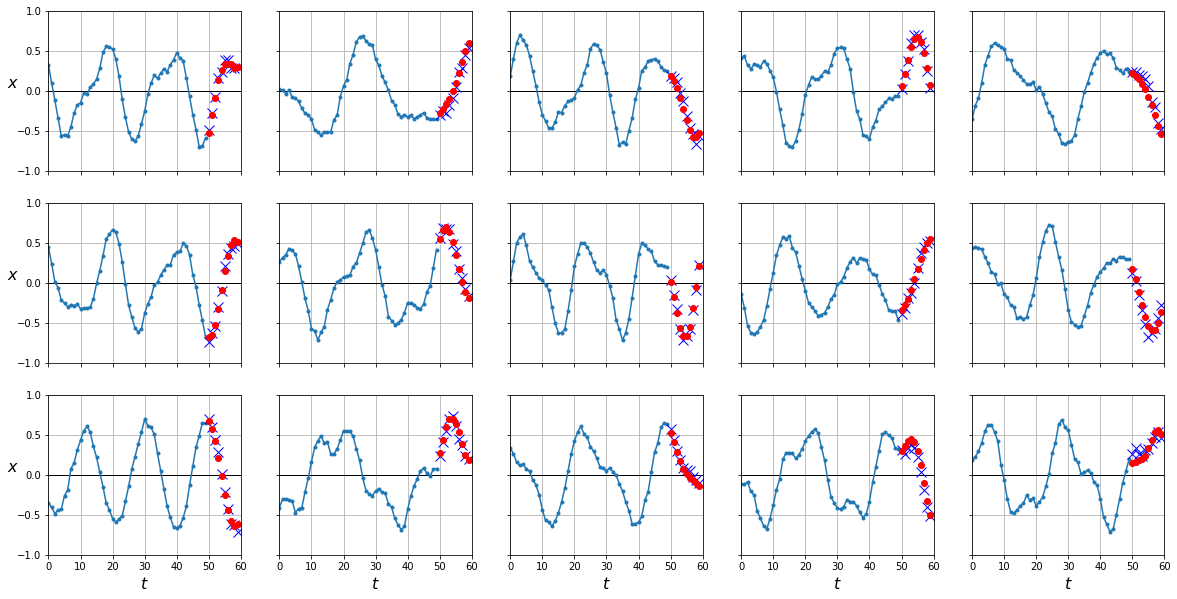

(1000, 10, 1)
(1000, 10)


0.0030943833

In [83]:
# Predicción sobre el set de datos de test:
inputs = torch.from_numpy(X_test[:, 10:]).unsqueeze(0)  # para el predict lea bien los datos (de este modo lee batch x largo x prof)
y_pred = predict(rnn_improved, inputs).cpu().numpy()

plot_series(X_test, y_test, y_pred)
print(y_test.shape)
print(y_pred.shape)
mean_squared_error(np.squeeze(y_test), y_pred)

# CONCLUSIONES:

•	Se logó mejorar el error cuadrático medio utilizando una RNN con diez predicciones al futuro, el mejor score obtenido con la RNN mejorada fue de 0.0030943833 mientras que con la MLP con una predicción al futuro se logró un score de 0.017902734

•	La RNN mejorada se entrenó con 50 epochs con la siguiente arquitectura:
3 redes recurrentes bidireccionales conectadas de 4 capas cada una.
